# Library

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

import numpy as np
seed = 0
np.random.seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
import json, os, uuid

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [2]:
reviews_df = pd.read_csv('Scrap_Reviews.csv')
reviews_df = pd.DataFrame(reviews_df)

In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  94130 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          16438 non-null   object
 9   repliedAt             16438 non-null   object
 10  appVersion            94130 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [4]:
unnecessary_columns = [
 'userName', 
 'userImage', 
 'thumbsUpCount', 
 'reviewCreatedVersion',
 'at',
 'replyContent',
 'repliedAt',
 'appVersion'
]

In [5]:
reviews_df = reviews_df.drop(columns=unnecessary_columns)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   reviewId  103500 non-null  object
 1   content   103500 non-null  object
 2   score     103500 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
reviews_df.head()

,reviewId,content,score
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1


In [7]:
print('Number of duplicated data:', reviews_df.duplicated().sum())

Number of duplicated data: 0


# Preprocessing

## Create Function

In [212]:
def cleaning_Text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Deleting '@' within text
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Deleting '#' within text
    text = re.sub(r'RT[\s]', '', text) # Deleting RT
    text = re.sub(r"http\s+", '', text) # Deleting url link
    text = re.sub(r'[0-9]+', '', text) # Deleting Number
    text = re.sub(r'[^\w\s]', '', text) # Deleting Unique Character

    text = text.replace('\n', '')
    text = text.translate(str.maketrans('', '', string.punctuation)) # Deleting punctuation
    text = text.strip(' ')
    return text

def casefolding_Text(text):
    text = text.lower()
    return text

def tokenizing_Text(text):
    text = word_tokenize(text)
    return text

def filtering_Text(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'])
    
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    
    text = filtered
    return text

def stemming_Text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    slangwords = {
        '@': 'di',
        'abis': 'habis',
        'wtb': 'beli',
        'wts': 'jual',
        'wtt': 'tukar',
        'masi': 'masih',
        'bgt': 'banget',
        'maks': 'maksimal',
        'min': 'minimal',
        'mantab': 'mantap',
        'kasi': 'kasih'
    }

    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text


## Text Cleaning

In [213]:
reviews_df['text_clean'] = reviews_df['content'].apply(cleaning_Text)
 
reviews_df['text_casefolding_Text'] = reviews_df['text_clean'].apply(casefolding_Text)
 
reviews_df['text_slangwords'] = reviews_df['text_casefolding_Text'].apply(fix_slangwords)
 
reviews_df['text_tokenizing_Text'] = reviews_df['text_slangwords'].apply(tokenizing_Text)
 
reviews_df['text_stopword'] = reviews_df['text_tokenizing_Text'].apply(filtering_Text)
 
reviews_df['text_akhir'] = reviews_df['text_stopword'].apply(toSentence)

In [214]:
reviews_df

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5,Dompet digital andalan Transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,"[dompet, digital, andalan, transaksi, jadi, su...","[dompet, digital, andalan, transaksi, super, m...",dompet digital andalan transaksi super mudah c...,11,positive
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4,Tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,"[tolong, beri, fitur, untuk, dapat, berkomunik...","[tolong, fitur, berkomunikasi, costumer, servi...",tolong fitur berkomunikasi costumer service ag...,-14,negative
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1,Sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,"[sangat, kecewa, dengan, aplikasi, ini, tidak,...","[kecewa, aplikasi, transfer, bank, lancar, tdk...",kecewa aplikasi transfer bank lancar tdk trans...,-6,negative
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5,Oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,"[oke, banget, aplikasi, ini, semua, fungsi, e,...","[oke, banget, aplikasi, fungsi, e, banking, tr...",oke banget aplikasi fungsi e banking transfer ...,4,positive
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1,Gopay Later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,"[gopay, later, dulu, tahun, an, sering, pake, ...","[gopay, later, pake, topup, pulsa, bayar, game...",gopay later pake topup pulsa bayar game dll ma...,-12,negative
...,...,...,...,...,...,...,...,...,...,...,...
103495,5f6d12b7-66c2-4436-bbdf-bdc64dae8aa7,Puas,5,Puas,puas,puas,[puas],[puas],puas,3,positive
103496,cb1c89e0-27a1-423c-81d5-c490fac9c16c,good,5,good,good,good,[good],[good],good,5,positive
103497,de6e9abc-79e1-4470-976c-c31429b4b369,Mantap,5,Mantap,mantap,mantap,[mantap],[mantap],mantap,5,positive
103498,1db1b461-9b85-48d2-a5e2-20227e11e80a,Mantppp,5,Mantppp,mantppp,mantppp,[mantppp],[mantppp],mantppp,0,neutral


## Labeling

In [199]:
import csv
import requests
from io import StringIO

### Get Dictionary

In [215]:
# Positive Dict
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Negative Dict
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

### Sentiment Checking

In [216]:
def sa_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score += lexicon_positive[word]
    
    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    
    return score, polarity

In [217]:
polarity = reviews_df['text_stopword'].apply(sa_lexicon_indonesia)
polarity = list(zip(*polarity))

reviews_df['sentiment_score'] = polarity[0]
reviews_df['sentiment'] = polarity[1]

In [218]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   reviewId               103500 non-null  object
 1   content                103500 non-null  object
 2   score                  103500 non-null  int64 
 3   text_clean             103500 non-null  object
 4   text_casefolding_Text  103500 non-null  object
 5   text_slangwords        103500 non-null  object
 6   text_tokenizing_Text   103500 non-null  object
 7   text_stopword          103500 non-null  object
 8   text_akhir             103500 non-null  object
 9   sentiment_score        103500 non-null  int64 
 10  sentiment              103500 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [219]:
reviews_df.head()

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5,Dompet digital andalan Transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,"[dompet, digital, andalan, transaksi, jadi, su...","[dompet, digital, andalan, transaksi, super, m...",dompet digital andalan transaksi super mudah c...,11,positive
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4,Tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,"[tolong, beri, fitur, untuk, dapat, berkomunik...","[tolong, fitur, berkomunikasi, costumer, servi...",tolong fitur berkomunikasi costumer service ag...,-14,negative
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1,Sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,"[sangat, kecewa, dengan, aplikasi, ini, tidak,...","[kecewa, aplikasi, transfer, bank, lancar, tdk...",kecewa aplikasi transfer bank lancar tdk trans...,-6,negative
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5,Oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,"[oke, banget, aplikasi, ini, semua, fungsi, e,...","[oke, banget, aplikasi, fungsi, e, banking, tr...",oke banget aplikasi fungsi e banking transfer ...,4,positive
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1,Gopay Later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,"[gopay, later, dulu, tahun, an, sering, pake, ...","[gopay, later, pake, topup, pulsa, bayar, game...",gopay later pake topup pulsa bayar game dll ma...,-12,negative


In [220]:
reviews_df['sentiment'].value_counts()

sentiment
positive    52412
negative    26923
neutral     24165
Name: count, dtype: int64

### Downsampling

In [206]:
from sklearn.utils import shuffle

In [221]:
positive_samples = reviews_df[reviews_df['sentiment'] == 'positive']
negative_samples = reviews_df[reviews_df['sentiment'] == 'negative']
neutral_samples = reviews_df[reviews_df['sentiment'] == 'neutral']

In [222]:
min_size = min(len(positive_samples), len(negative_samples), len(neutral_samples))

In [223]:
positive_downsampled = positive_samples.sample(min_size, random_state=42)
negative_downsampled = negative_samples.sample(min_size, random_state=42)
neutral_downsampled = neutral_samples.sample(min_size, random_state=42)

In [224]:
balanced_df = pd.concat([positive_downsampled, negative_downsampled, neutral_downsampled])

In [225]:
balanced_df = shuffle(balanced_df, random_state=42)
balanced_df.head()

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment
45761,8de2eaf2-eb01-4f55-b2da-dd6471f64514,Gopay mantul pendaftaran gk ribet. Menu yg ada...,5,Gopay mantul pendaftaran gk ribet Menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,"[gopay, mantul, pendaftaran, gk, ribet, menu, ...","[gopay, mantul, pendaftaran, gk, ribet, menu, ...",gopay mantul pendaftaran gk ribet menu yg gopa...,-9,negative
20279,0ae1c9d9-f48d-4418-b87f-a568cebc738b,Gak nyesel udh download GoPay Transfer.. Setia...,5,Gak nyesel udh download GoPay Transfer Setiap ...,gak nyesel udh download gopay transfer setiap ...,gak nyesel udh download gopay transfer setiap ...,"[gak, nyesel, udh, download, gopay, transfer, ...","[nyesel, udh, download, gopay, transfer, mo, t...",nyesel udh download gopay transfer mo tf bank ...,-4,negative
35116,a825dbfd-3bb6-4dad-9c9c-06c751e91d13,Puas dengan segala pelayanannya dalam bertrans...,5,Puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,"[puas, dengan, segala, pelayanannya, dalam, be...","[puas, pelayanannya, bertransaksi, jaman, ribet]",puas pelayanannya bertransaksi jaman ribet,0,neutral
40709,ae1011ee-f06a-4372-b8cd-e998113b7170,Susah update berkas nya aga ribet nelp call ce...,1,Susah update berkas nya aga ribet nelp call ce...,susah update berkas nya aga ribet nelp call ce...,susah update berkas nya aga ribet nelp call ce...,"[susah, update, berkas, nya, aga, ribet, nelp,...","[susah, update, berkas, aga, ribet, nelp, call...",susah update berkas aga ribet nelp call centernya,-7,negative
21646,93b5aeb0-5122-4940-93ba-d5a27103969f,sangat membantu,5,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],membantu,0,neutral


In [25]:
balanced_df['sentiment'].value_counts()

sentiment
negative    24753
neutral     24753
positive    24753
Name: count, dtype: int64

In [26]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
balanced_df['sentiment_class'] = balanced_df['sentiment'].map(sentiment_mapping)

In [27]:
balanced_df['sentiment_class'].value_counts()

sentiment_class
0    24753
1    24753
2    24753
Name: count, dtype: int64

In [28]:
balanced_df.head(3)

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment,sentiment_class
26366,a9b6039d-38f7-4225-9bc6-972cb2c8a24d,"Ini gimana sih , saldoku hilang disini 374K , ...",1,Ini gimana sih saldoku hilang disini K giman...,ini gimana sih saldoku hilang disini k giman...,ini gimana sih saldoku hilang disini k gimana ...,"[ini, gimana, sih, saldoku, hilang, disini, k,...","[gimana, saldoku, hilang, k, gimana, gopay, ma...",gimana saldoku hilang k gimana gopay maksudnya...,-2,negative,0
15110,331af66b-55bd-44cc-a05b-ad3f90ad4f5c,"Makin kesini makin bad ,sering freeze sudah up...",2,Makin kesini makin bad sering freeze sudah upd...,makin kesini makin bad sering freeze sudah upd...,makin kesini makin bad sering freeze sudah upd...,"[makin, kesini, makin, bad, sering, freeze, su...","[kesini, bad, freeze, update, install, ulang, ...",kesini bad freeze update install ulang udah gr...,0,neutral,1
53938,10f0656f-f1dd-43ec-8f29-d96532100767,tidak dapat digunakan,1,tidak dapat digunakan,tidak dapat digunakan,tidak dapat digunakan,"[tidak, dapat, digunakan]",[],,0,neutral,1


## Split Data

In [29]:
# Feature
X = balanced_df['text_akhir']

# Label
y = balanced_df['sentiment_class']

In [30]:
# Check
y

26366    0
15110    1
53938    1
76383    1
72743    2
        ..
3970     0
76532    2
96512    1
93454    2
59665    2
Name: sentiment_class, Length: 74259, dtype: int64

In [31]:
TEST_SIZE_10 = 0.1 # untuk Model 1

TEST_SIZE_20 = 0.2 # untuk Model 2

TEST_SIZE_30 = 0.3 # untuk Model 3

In [32]:
# Train Split Function
def train_split(X, y, TEST_SIZE):
    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=42
                                    )
    
    X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=42
                                    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
# Split 1
X_train_1, X_val_1, X_test_1, y_train_1, y_val_1, y_test_1 = train_split(X, y, TEST_SIZE_10)

# Split 2
X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = train_split(X, y, TEST_SIZE_20)

# Split 3
X_train_3, X_val_3, X_test_3, y_train_3, y_val_3, y_test_3 = train_split(X, y, TEST_SIZE_30)

## Feature Extraction

### TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
tfidf = TfidfVectorizer(
    max_features=200,
    min_df=17,
    max_df=0.8
)

### Word Embedding

In [36]:
from gensim.models import Word2Vec

In [37]:
def get_feature_vector(review, model):
    words = review.split()
    feature_vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    if np.isnan(feature_vector).any():  # Handle empty feature vector
        feature_vector = np.zeros(model.vector_size)
    return feature_vector

#### Train Data

In [38]:
reviews_train = X_train_2

In [39]:
tokenized_train_texts = [review.split() for review in reviews_train]

train_W2V = Word2Vec(sentences=tokenized_train_texts, vector_size=200, window=50, min_count=1, workers=4)
train_W2V.train(tokenized_train_texts, total_examples=len(tokenized_train_texts), epochs=10)

(2153817, 2687970)

#### Validation Data

In [40]:
reviews_val = X_val_2

In [41]:
tokenized_val_texts = [review.split() for review in reviews_val]

val_W2V = Word2Vec(sentences=tokenized_val_texts, vector_size=200, window=50, min_count=1, workers=4)
val_W2V.train(tokenized_val_texts, total_examples=len(tokenized_val_texts), epochs=10)

(259824, 326830)

## Data Preparation

### TFIDF Scenario

#### Train Data

In [111]:
from sklearn.manifold import TSNE

In [159]:
tfidf.fit(X_train_1)

X_tfidf_train = tfidf.transform(X_train_1)
X_tfidf_val = tfidf.transform(X_val_1)
X_tfidf_test = tfidf.transform(X_test_1)

In [126]:
X_tfidf_train = X_tfidf_train.toarray()
X_tfidf_val = X_tfidf_val.toarray()

In [127]:
X_tfidf_train_df = pd.DataFrame(X_tfidf_train, columns=tfidf.get_feature_names_out())
X_tfidf_train_df

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.831748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286597,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
X_tfidf_train_df.describe().T.sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
suruh,66833.0,0.001365,0.024693,0.0,0.0,0.0,0.0,1.0
token,66833.0,0.001496,0.027160,0.0,0.0,0.0,0.0,1.0
sampe,66833.0,0.001505,0.026962,0.0,0.0,0.0,0.0,1.0
muncul,66833.0,0.001512,0.028778,0.0,0.0,0.0,0.0,1.0
email,66833.0,0.001604,0.028214,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
aplikasi,66833.0,0.046687,0.148372,0.0,0.0,0.0,0.0,1.0
gopay,66833.0,0.053380,0.152339,0.0,0.0,0.0,0.0,1.0
mantap,66833.0,0.055539,0.212561,0.0,0.0,0.0,0.0,1.0
membantu,66833.0,0.068006,0.227973,0.0,0.0,0.0,0.0,1.0


In [130]:
'''
tfidf_tsne = TSNE(n_components=2, random_state=42)
X_tfidf_tsne = tfidf_tsne.fit_transform(X_tfidf_train)
'''

'\ntfidf_tsne = TSNE(n_components=2, random_state=42)\nX_tfidf_tsne = tfidf_tsne.fit_transform(X_tfidf_train)\n'

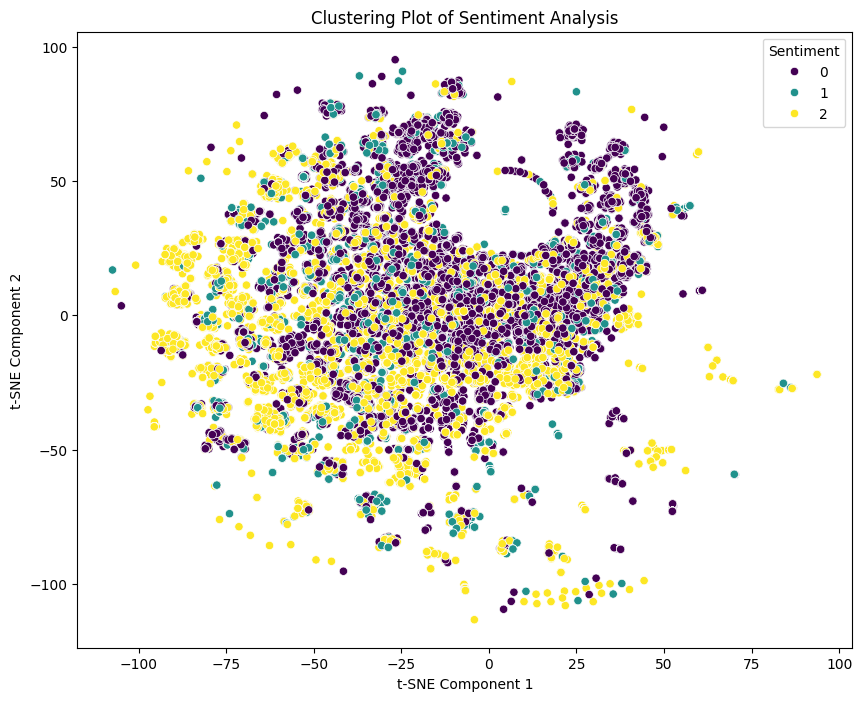

In [118]:
'''
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tfidf_tsne[:, 0], y=X_tfidf_tsne[:, 1], hue=y_train_1, palette='viridis')
plt.title("Clustering Plot of Sentiment Analysis")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()
'''

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# df_tsne = pd.DataFrame(X_tfidf_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
# df_tsne['sentiment'] = y_train_1

In [ ]:
'''
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']
sentiments = [0, 1, 2]

for sentiment in np.unique(y_tsne):
    indices = df_tsne['sentiment'] == sentiment
    ax.scatter(df_tsne.loc[indices, 'Dim1'], df_tsne.loc[indices, 'Dim2'], df_tsne.loc[indices, 'Dim3'], c=colors[sentiment], label=sentiments[sentiment])

ax.set_title("Visualisasi t-SNE (3D)")
ax.set_xlabel("Dimensi 1")
ax.set_ylabel("Dimensi 2")
ax.set_zlabel("Dimensi 3")
ax.legend()
plt.show()
'''

In [131]:
# Standardization
scaler = StandardScaler()

X_tfidf_train_scaled = scaler.fit_transform(X_tfidf_train)
X_tfidf_val_scaled = scaler.transform(X_tfidf_val)

In [132]:
X_tfidf_train_scaled_df = pd.DataFrame(X_tfidf_train_scaled, columns=tfidf.get_feature_names_out())
X_tfidf_train_scaled_df

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
1,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,26.67584,-0.078569,-0.05429,-0.174398
2,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
3,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,26.477684,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
4,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66828,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
66829,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
66830,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398
66831,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,1.616966,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.06030,-0.078569,-0.05429,-0.174398


In [133]:
X_tfidf_train_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
admin,66833.0,-9.164452e-17,1.000007,-0.105049,-0.105049,-0.105049,-0.105049,17.759472
aja,66833.0,-2.421882e-16,1.000007,-0.149578,-0.149578,-0.149578,-0.149578,14.411563
akun,66833.0,-1.233267e-16,1.000007,-0.109751,-0.109751,-0.109751,-0.109751,16.838079
aman,66833.0,1.944522e-16,1.000007,-0.131150,-0.131150,-0.131150,-0.131150,11.201297
aneh,66833.0,-9.781086e-18,1.000007,-0.066053,-0.066053,-0.066053,-0.066053,28.622975
...,...,...,...,...,...,...,...,...
udh,66833.0,-5.189557e-17,1.000007,-0.081129,-0.081129,-0.081129,-0.081129,25.589166
update,66833.0,4.550331e-17,1.000007,-0.060300,-0.060300,-0.060300,-0.060300,26.675840
upgrade,66833.0,-1.297057e-17,1.000007,-0.078569,-0.078569,-0.078569,-0.078569,23.008814
utk,66833.0,3.146958e-17,1.000007,-0.054290,-0.054290,-0.054290,-0.054290,30.403380


In [142]:
# Reduce Dimension with PCA 
pca_svm = PCA(n_components=200)
X_tfidf_train_pca = pca_svm.fit_transform(X_tfidf_train_scaled)
X_tfidf_val_pca = pca_svm.transform(X_tfidf_val_scaled)

In [143]:
X_tfidf_train_pca_df = pd.DataFrame(X_tfidf_train_pca, columns=pca_svm.get_feature_names_out())
X_tfidf_train_pca_df

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca190,pca191,pca192,pca193,pca194,pca195,pca196,pca197,pca198,pca199
0,-0.339193,0.745190,0.157678,-0.516628,0.000933,-0.341259,-0.266269,-0.112670,0.801452,-0.510399,...,0.086066,-0.733977,-0.028535,0.041755,0.103300,-0.036784,0.018022,-0.066758,0.000732,-0.205981
1,0.671657,-0.970073,0.004426,0.309019,-0.830272,0.321437,-0.031149,-0.915079,0.315627,-1.122619,...,-0.041357,-0.426050,-0.093774,0.103217,-0.111687,-0.067772,0.044072,0.011516,-0.008057,-0.163011
2,-0.720072,-0.228913,-0.116639,0.191545,-0.073167,-0.031244,0.083497,-0.134339,-0.255505,0.080094,...,0.002355,-0.015456,0.000654,0.005135,0.024408,-0.021575,-0.081113,0.030338,-0.131037,-1.102034
3,0.343943,-0.813395,-0.220662,-0.423336,-0.790350,0.188136,-0.464398,-0.951623,-0.485369,0.782010,...,0.475014,0.415556,-0.017210,0.066380,0.035551,0.174847,-0.069751,-0.044093,-0.060337,0.161993
4,-0.720072,-0.228913,-0.116639,0.191545,-0.073167,-0.031244,0.083497,-0.134339,-0.255505,0.080094,...,0.002355,-0.015456,0.000654,0.005135,0.024408,-0.021575,-0.081113,0.030338,-0.131037,-1.102034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66828,-1.210936,-0.410472,-0.251541,0.449470,-0.190780,-0.085655,0.175537,-0.374283,-0.668278,0.147306,...,-0.012375,0.062468,0.016341,-0.023619,-0.017516,0.004502,0.055553,-0.024384,0.085091,0.564904
66829,3.424445,-1.700899,2.077415,2.709267,-1.719976,-0.547772,2.952546,1.243372,-0.530520,0.825561,...,-1.322909,-0.454929,0.134818,0.022525,0.013808,0.106252,-0.008893,-0.065694,0.081599,0.315562
66830,-0.433839,-0.731686,-0.313267,0.097185,0.007314,0.489760,0.008169,0.305635,-0.809301,-0.397299,...,0.175659,-0.036556,0.047136,-0.040091,0.045892,0.025748,-0.142564,-0.035756,0.008492,0.096041
66831,0.652274,1.872057,-2.527508,-1.225429,1.402719,-1.574524,-0.240446,-0.813240,-0.452467,0.228576,...,0.384403,0.425163,-0.305386,-0.294873,0.311642,-1.215989,0.135219,-0.021481,0.304477,0.424642


In [146]:
X_tfidf_train_pca_df.describe().T

,count,mean,std,min,25%,50%,75%,max
pca0,66833.0,2.343102e-15,1.598837,-1.811343,-1.142032,-0.720072,0.551575,9.078863
pca1,66833.0,-1.139124e-15,1.408178,-4.886341,-0.328791,-0.228913,0.208331,16.859721
pca2,66833.0,-9.722612e-17,1.362565,-8.995765,-0.234358,-0.116639,0.001717,9.932309
pca3,66833.0,3.019379e-17,1.312335,-8.519197,-0.163780,0.191545,0.359405,12.027532
pca4,66833.0,4.512695e-15,1.278168,-7.077920,-0.190780,-0.073167,0.016663,20.577843
...,...,...,...,...,...,...,...,...
pca195,66833.0,-6.405548e-17,0.692990,-12.712360,-0.021575,0.005559,0.024937,12.192984
pca196,66833.0,1.677084e-15,0.671320,-13.792282,-0.081113,0.024521,0.056306,10.458820
pca197,66833.0,-2.692403e-15,0.646901,-21.129396,-0.024384,-0.005660,0.030338,19.261428
pca198,66833.0,-7.377278e-16,0.638519,-17.808696,-0.081066,0.029239,0.061541,19.190400


#### Visualize

In [64]:
# y_train_1.value_counts()

sentiment_class
2    22357
0    22279
1    22197
Name: count, dtype: int64

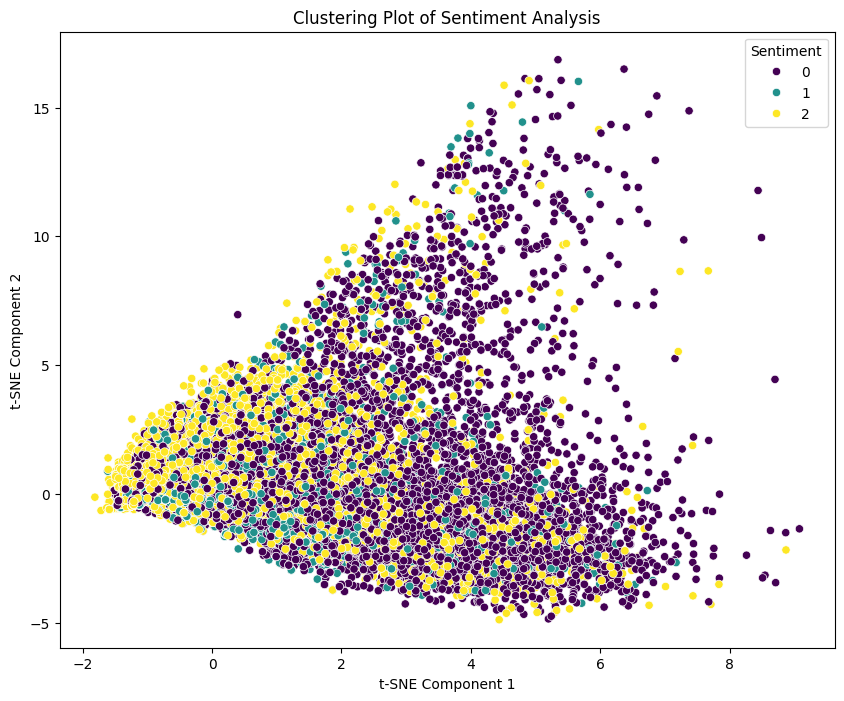

In [85]:
'''
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tfidf_train_pca[:, 0], y=X_tfidf_train_pca[:, 1], hue=y_train_1, palette='viridis')
plt.title("Clustering Plot of Sentiment Analysis")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()
'''

### Word Embedding (Word2Vec) Scenario

#### Train Data

In [ ]:
X_we_train = np.array([get_feature_vector(review, train_W2V) for review in reviews_train])

X_we_train_df = pd.DataFrame(X_we_train, columns=train_W2V.get_feature_names_out())
X_we_train_df

c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,0.523491,0.104900,-0.339939,0.962797,0.054273,0.169441,-0.248453,0.026071,-1.109555,0.280017,...,-0.006173,0.085396,0.097928,0.209203,-0.135311,-0.162035,0.649774,0.060463,0.133917,0.338933
1,-0.134497,-0.299242,-0.632695,0.125171,0.630144,0.044229,-0.019970,0.189139,-0.427737,1.168198,...,0.327142,-0.059111,-0.122501,-0.651619,0.931660,0.501525,0.071774,-0.814543,0.233602,0.842068
2,0.171978,0.094751,-0.148037,0.531153,0.385665,-0.224004,-0.145237,0.536292,-0.329957,0.334272,...,0.334768,-0.042004,-0.307171,-0.174864,0.626911,0.225814,0.547169,-0.468217,0.173172,0.139956
3,0.029025,0.000568,0.051947,-0.254083,0.978189,-0.106943,0.368087,0.884037,0.200739,0.249804,...,0.611850,0.208850,-0.464120,-0.177931,0.636277,0.192962,0.299727,-0.232212,0.083425,-0.215140
4,0.241323,0.190215,-0.510865,-0.210173,1.097623,0.228281,0.596084,0.724919,0.206574,0.512507,...,-0.095894,0.264268,-0.575233,-0.389840,0.342787,0.205671,0.228433,-0.363938,0.249432,-0.043927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59402,0.052246,-0.027746,-0.114719,-0.234778,0.887348,-0.458231,0.857572,0.993807,0.179707,-0.073704,...,0.494770,-0.168240,-0.016566,0.046605,0.174163,-0.037817,0.359026,-0.076268,-0.101374,-0.047412
59403,-0.140668,0.340013,-0.165387,0.622493,-0.080908,-0.321430,-0.419784,0.201171,-0.743536,0.765630,...,-0.366122,-0.373272,-0.087894,-0.292788,0.111680,-0.187921,0.255806,-0.318663,0.104019,-0.040274
59404,0.820252,-0.097178,0.328459,1.194535,-0.515297,-0.665676,-0.559641,-0.729438,-1.062099,1.284496,...,-1.395947,-1.050533,-0.504673,-0.421484,-0.148450,0.248609,0.461455,-0.655326,0.307395,-0.361657
59405,0.777856,-0.070534,-0.189285,0.517955,0.263309,-0.799659,-0.664639,0.295156,-0.471907,1.564984,...,-0.187312,-0.642499,-0.469130,0.016848,1.157725,0.671928,-0.506538,-1.436427,0.627847,0.185535


In [ ]:
X_we_train_df.describe()

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
count,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,...,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000,59407.000000
mean,0.207045,0.075441,-0.181459,0.185704,0.421519,-0.283079,-0.195950,0.360137,-0.282439,0.656660,...,-0.062067,-0.192380,-0.203501,-0.216023,0.404926,0.278946,0.068187,-0.454833,0.261650,0.039271
std,0.380159,0.361649,0.267903,0.570354,0.575828,0.309191,0.481435,0.468460,0.567018,0.488629,...,0.519953,0.371659,0.319389,0.392333,0.413155,0.362346,0.455986,0.369623,0.411984,0.406062
min,-1.569077,-2.067559,-2.515874,-2.622592,-2.494352,-2.717967,-3.196374,-2.136614,-3.703145,-0.806677,...,-2.827940,-3.781231,-2.070510,-1.946458,-2.145037,-2.983835,-2.576771,-3.176914,-1.957784,-2.099398
25%,-0.008238,-0.103682,-0.302629,-0.210173,0.000442,-0.466061,-0.478339,0.028346,-0.668940,0.257067,...,-0.361416,-0.307582,-0.398934,-0.415823,0.103050,0.024110,-0.232968,-0.631142,-0.000420,-0.193352
50%,0.113387,0.047768,-0.162924,0.070446,0.393654,-0.281562,-0.172580,0.323779,-0.150760,0.643973,...,-0.054962,-0.109630,-0.154288,-0.238236,0.375701,0.241672,0.062326,-0.401760,0.228472,0.000000
75%,0.389239,0.239822,0.000000,0.522597,0.780841,-0.065128,0.083700,0.643050,0.103743,1.033784,...,0.188056,0.000000,0.000000,0.000000,0.715650,0.490970,0.334415,-0.199861,0.489957,0.261455
max,2.579173,2.842777,2.076134,3.220412,2.698032,1.364760,1.572218,1.806391,1.844462,3.445553,...,1.867228,2.399862,3.327748,2.776445,2.775033,3.415306,3.685679,1.898932,3.235299,2.271853


In [ ]:
# Standardization
scaler = StandardScaler()

X_we_train_scaled = scaler.fit_transform(X_we_train)

In [ ]:
X_we_train_scaled_df = pd.DataFrame(X_we_train_scaled, columns=tfidf.get_feature_names_out())
X_we_train_scaled_df

In [ ]:
# Reduce Dimension with PCA 
pca_svm = PCA(n_components=0.95)
X_we_train_pca = pca_svm.fit_transform(X_we_train_scaled)

In [ ]:
X_we_train_pca_df = pd.DataFrame(X_we_train_pca, columns=tfidf.get_feature_names_out())
X_we_train_pca_df

In [ ]:
X_we_train_pca_df.describe()

#### Validation Data

In [ ]:
X_we_val = np.array([get_feature_vector(review, val_W2V) for review in reviews_val])

X_we_val_df = pd.DataFrame(X_we_val, columns=val_W2V.get_feature_names_out())
X_we_val_df

c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,-0.002886,-0.003069,0.001790,-0.001169,-0.001303,-0.003369,0.003338,0.003933,0.002725,0.004134,...,0.001235,-0.004269,-0.003713,-0.000733,0.004173,-0.003473,-0.000766,0.002715,-0.000005,-0.000561
1,0.190716,-0.124392,-0.025532,0.279157,0.231754,-0.264382,-0.033390,0.471347,-0.214834,0.185571,...,0.288331,-0.142923,-0.056726,-0.148839,0.163610,0.211768,0.091308,-0.355064,0.060380,-0.157234
2,0.416334,-0.272200,-0.050693,0.615324,0.490736,-0.584422,-0.062905,1.026608,-0.463756,0.398736,...,0.636846,-0.314319,-0.119209,-0.324725,0.344431,0.462313,0.199799,-0.766580,0.132527,-0.335611
3,0.030946,-0.021366,0.000958,0.040852,0.032817,-0.045278,-0.007339,0.079637,-0.033741,0.033003,...,0.050955,-0.019134,-0.013375,-0.024805,0.023716,0.033745,0.018099,-0.060257,0.008705,-0.021590
4,0.299918,-0.200471,-0.032663,0.435113,0.356063,-0.425993,-0.052022,0.738730,-0.328935,0.284670,...,0.464924,-0.225013,-0.090469,-0.232338,0.250021,0.332348,0.136551,-0.556454,0.095874,-0.246154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7421,0.229903,-0.153806,-0.027580,0.340348,0.273901,-0.324410,-0.036956,0.566172,-0.257914,0.220677,...,0.352512,-0.175643,-0.065002,-0.177589,0.188901,0.254161,0.109882,-0.424734,0.074618,-0.186008
7422,0.195956,-0.123841,-0.019811,0.278601,0.235536,-0.275275,-0.030637,0.476089,-0.210942,0.180685,...,0.298829,-0.145037,-0.055877,-0.152257,0.160203,0.215079,0.088571,-0.357447,0.066989,-0.155792
7423,0.266114,-0.178654,-0.031866,0.388587,0.317443,-0.376684,-0.043576,0.654094,-0.291379,0.254315,...,0.411139,-0.200224,-0.079966,-0.205037,0.218424,0.296157,0.123192,-0.494749,0.088786,-0.219112
7424,0.003691,-0.000039,0.003820,0.002976,0.004403,0.003880,0.004694,-0.003059,0.001851,-0.004881,...,0.001982,-0.000247,-0.002659,-0.004688,0.001564,-0.004513,0.004709,0.002936,0.004894,0.004818


In [ ]:
X_we_val_df.describe()

In [ ]:
# Standardization
X_we_val_scaled = scaler.transform(X_we_val)

In [ ]:
X_we_val_scaled_df = pd.DataFrame(X_we_val_scaled, columns=tfidf.get_feature_names_out())
X_we_val_scaled_df

In [ ]:
# Reduce Dimension with PCA 
X_we_val_pca = pca_svm.transform(X_we_val_scaled)

In [ ]:
X_we_val_pca_df = pd.DataFrame(X_we_val_pca, columns=tfidf.get_feature_names_out())
X_we_val_pca_df

In [ ]:
X_we_val_pca_df.describe()

#### Visualize

In [ ]:
# y_train_2.shape

(59407,)

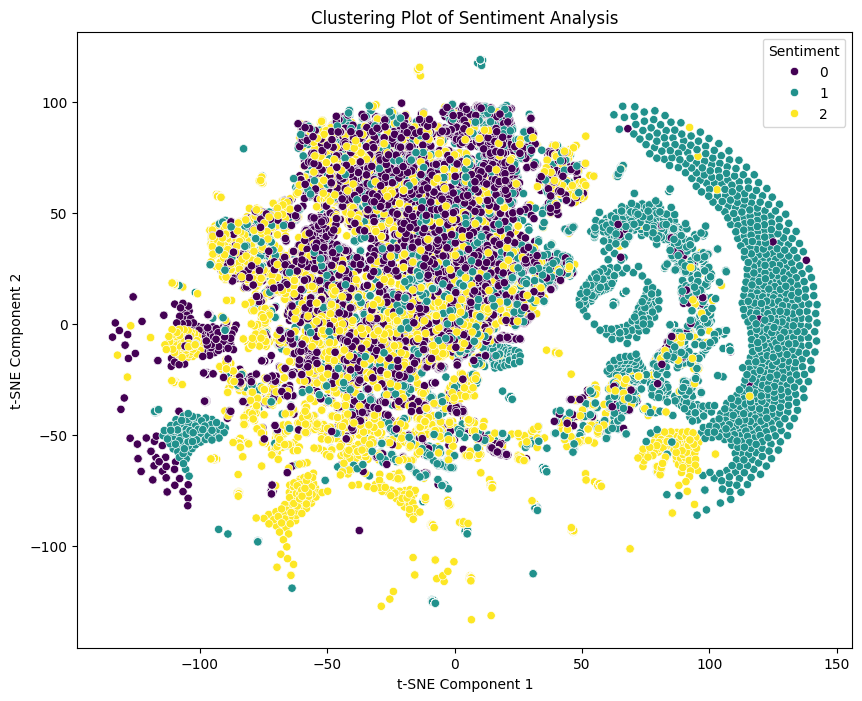

In [ ]:
'''
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_we_tsne[:, 0], y=X_we_tsne[:, 1], hue=y_train_2, palette='viridis')
plt.title("Clustering Plot of Sentiment Analysis")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()
'''

### RNN Scenario

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'keras'

#### Train Data

In [ ]:
X_nn_train = X_train_3

tokenizer = Tokenizer(num_words=10_000)
tokenizer.fit_on_texts(X_nn_train)

X_rnn = tokenizer.texts_to_sequences(X_nn_train)
X_rnn = pad_sequences(X_rnn, maxlen=100)

In [ ]:
encoder = LabelEncoder()
y_rnn_train = encoder.fit_transform(y_train_3)
y_rnn_train = to_categorical(y_rnn_train)

#### Validation Data

In [ ]:
X_nn_val = X_val_3

tokenizer = Tokenizer(num_words=10_000)
tokenizer.fit_on_texts(X_nn_val)

X_rnn_val = tokenizer.texts_to_sequences(X_nn_val)
X_rnn_val = pad_sequences(X_rnn_val, maxlen=100)

In [ ]:
encoder = LabelEncoder()
y_rnn_val = encoder.fit_transform(y_val_3)
y_rnn_val = to_categorical(y_rnn_val)

# Modeling

## SVM Model for TFIDF Scenario

### Training

In [138]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [479]:
# X_train = X_tfidf_train_pca
# X_val = X_tfidf_val_pca
# y_train = y_train_1
# y_val = y_val_1

In [139]:
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')

In [147]:
svm_model.fit(X_tfidf_train_pca, y_train_1)

SVC()

### Evaluation

Accuracy SVM: 0.86

Classification Report SVM:
               precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1240
     neutral       0.86      0.89      0.87      1282
    positive       0.90      0.82      0.86      1191

    accuracy                           0.86      3713
   macro avg       0.86      0.86      0.86      3713
weighted avg       0.86      0.86      0.86      3713

Confusion Matrix SVM:
 [[1074   97   69]
 [ 105 1143   34]
 [ 118   95  978]]


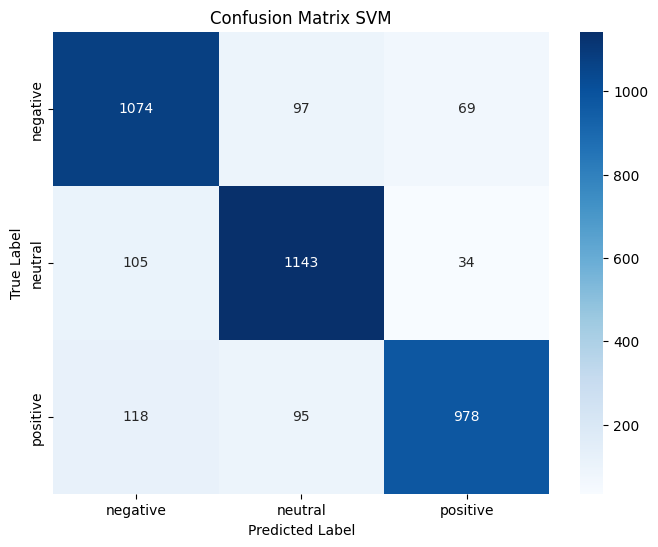

In [148]:
y_pred_svm = svm_model.predict(X_tfidf_val_pca)

# Akurasi
accuracy_svm = accuracy_score(y_val_1, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.2f}")

# Report
report_svm = classification_report(y_val_1, y_pred_svm, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report SVM:\n", report_svm)

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_val_1, y_pred_svm)
print("Confusion Matrix SVM:\n", conf_matrix_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.show()

### Model Testing / Inference

In [227]:
X_Inference = balanced_df['content']

In [229]:
X_Train, X_Test = train_test_split(X_Inference, test_size=0.05, random_state=42, shuffle=True)

In [230]:
X_Test.shape

(3625,)

In [233]:
X_Test_df = pd.DataFrame(X_Test)
X_Test_df

,content
23157,Sangat menyenangkan menggunakan GoPay
71396,Mantap
37219,suka repot kalau disuruh emak isi token listri...
97480,mantap
73004,Sangat bagusssssss
...,...
39863,"Bagus Sekali, Dengan Gopay Semua Transaksi Jdi..."
35831,sangat membantu
11148,"Aplikasinya mudah dipake, fiturnya ada isi pul..."
75852,bagus aplikasi ya bayar apa aja gampang buat k...


In [231]:
X_tfidf_Inference = tfidf.fit_transform(X_Test)

In [232]:
X_tfidf_Inference.shape

(3625, 200)

In [235]:
X_tfidf_Inference = X_tfidf_Inference.toarray()

In [236]:
X_tfidf_Inference_df = pd.DataFrame(X_tfidf_Inference, columns=tfidf.get_feature_names_out())
X_tfidf_Inference_df

,ada,admin,aja,aku,akun,aman,apa,apapun,apk,aplikasi,...,uang,udah,udh,untuk,up,upgrade,wallet,ya,yang,yg
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.000000,0.0,0.289723,0.0,0.0,0.0,0.00000,0.0,0.276054,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3621,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3622,0.155656,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.252229,...,0.0,0.0,0.0,0.17071,0.0,0.0,0.0,0.00000,0.0,0.0
3623,0.000000,0.0,0.256737,0.0,0.0,0.0,0.28562,0.0,0.000000,0.173371,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.26331,0.0,0.0


In [239]:
X_tfidf_Inference_scaled = scaler.transform(X_tfidf_Inference)

In [240]:
X_tfidf_Inference_pca = pca_svm.transform(X_tfidf_Inference_scaled)

In [241]:
predictions_svm2 = svm_model.predict(X_tfidf_Inference_pca)

labeling2 = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predictions_svm_labels2 = [labeling2[pred] for pred in predictions_svm2]

In [243]:
results_svm2 = pd.DataFrame({
    'Review': X_Test,
    'Sentiment': predictions_svm_labels2
})
results_svm2.to_csv('results_svm', index=True)
results_svm2['Sentiment'].value_counts()

Sentiment
Negative    2164
Neutral      787
Positive     674
Name: count, dtype: int64

In [161]:
# Testing_Data == X_test_1
X_tfidf_test.shape

(3713, 200)

In [186]:
X_test_1_df = pd.DataFrame(X_test_1)
X_test_1_df

,text_akhir
75041,bagus
67157,good
63075,kode otp g masuk
45045,alhamdulillahsemoga aplikasi mempermudah tuk b...
9827,ngehubungin gopay play store
...,...
65693,mantap
31131,membantu joss smg berkembang
91752,oje
61016,bagus


In [172]:
X_tfidf_test = X_tfidf_test.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [173]:
X_tfidf_test_df = pd.DataFrame(X_tfidf_test, columns=tfidf.get_feature_names_out())
X_tfidf_test_df

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488265,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
X_tfidf_test_scaled = scaler.transform(X_tfidf_test)

In [176]:
X_tfidf_test_scaled = pd.DataFrame(X_tfidf_test_scaled, columns=tfidf.get_feature_names_out())
X_tfidf_test_scaled

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
1,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
2,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
3,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,2.976183,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
4,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
3709,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
3710,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398
3711,-0.105049,-0.149578,-0.109751,-0.13115,-0.066053,-0.07272,-0.157049,-0.314663,-0.143062,-0.085444,...,-0.200863,-0.056282,-0.062048,-0.13122,-0.130985,-0.081129,-0.0603,-0.078569,-0.05429,-0.174398


In [178]:
X_tfidf_test_pca = pca_svm.transform(X_tfidf_test_scaled)

c:\Users\ACER\.conda\envs\SA_with_TF\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [179]:
X_tfidf_test_pca_df = pd.DataFrame(X_tfidf_test_pca, columns=tfidf.get_feature_names_out())
X_tfidf_test_pca_df

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,-1.244274,-0.303838,-0.234358,0.451015,-0.167586,-0.090883,0.079094,-0.262143,-0.460349,0.093437,...,-0.004271,0.035721,0.019551,-0.001629,-0.006478,0.008433,0.024521,-0.013706,0.057100,0.477975
1,-1.242511,-0.461458,-0.272704,0.474448,-0.201912,-0.110778,0.281323,-0.405600,-0.663860,0.293160,...,0.014496,0.055347,0.015073,0.011696,0.009640,0.024293,0.064562,-0.018997,0.037921,0.639416
2,2.452694,-1.884570,1.970394,4.716853,3.071991,0.372601,0.524815,-0.395938,-0.932779,0.092718,...,-1.129545,-0.791417,0.419436,-0.008552,0.068131,0.148062,-0.254292,0.144536,0.082185,0.047856
3,-0.807859,0.661867,-0.172060,-0.028500,0.442786,-0.052626,-0.218918,0.643252,1.081427,-0.264430,...,-0.137806,-1.274212,0.480841,0.047393,0.037524,0.124246,0.005528,0.010852,0.018897,0.143534
4,0.247004,-0.288179,-0.198670,-0.331301,-0.314160,-0.032442,-0.111093,0.410995,0.322881,-0.130043,...,-0.152421,-0.589325,0.073572,0.099865,-0.100473,0.005559,0.026022,-0.032154,-0.000513,-0.461788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,-1.208486,-0.296608,-0.109224,0.302226,-0.184459,-0.068143,0.195843,-0.381092,-0.600354,0.181846,...,0.007410,0.082582,0.013320,0.013032,-0.015515,0.019260,0.044995,-0.014540,0.061541,0.476431
3709,-1.224565,-0.214582,-0.220553,0.340303,-0.060814,-0.039935,0.127559,-0.107778,-0.389464,0.186197,...,0.006050,-0.058991,0.041761,0.006630,-0.008658,0.019106,0.056306,-0.005660,0.053507,0.435129
3710,-0.720072,-0.228913,-0.116639,0.191545,-0.073167,-0.031244,0.083497,-0.134339,-0.255505,0.080094,...,0.002355,-0.015456,0.000654,0.005135,0.024408,-0.021575,-0.081113,0.030338,-0.131037,-1.102034
3711,-1.244274,-0.303838,-0.234358,0.451015,-0.167586,-0.090883,0.079094,-0.262143,-0.460349,0.093437,...,-0.004271,0.035721,0.019551,-0.001629,-0.006478,0.008433,0.024521,-0.013706,0.057100,0.477975


In [180]:
predictions_svm = svm_model.predict(X_tfidf_test_pca)

labeling = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predictions_svm_labels = [labeling[pred] for pred in predictions_svm]

Accuracy SVM: 0.87

Classification Report SVM:
               precision    recall  f1-score   support

    negative       0.83      0.88      0.85      1234
     neutral       0.86      0.88      0.87      1274
    positive       0.92      0.84      0.88      1205

    accuracy                           0.87      3713
   macro avg       0.87      0.87      0.87      3713
weighted avg       0.87      0.87      0.87      3713

Confusion Matrix SVM:
 [[1074   97   69]
 [ 105 1143   34]
 [ 118   95  978]]


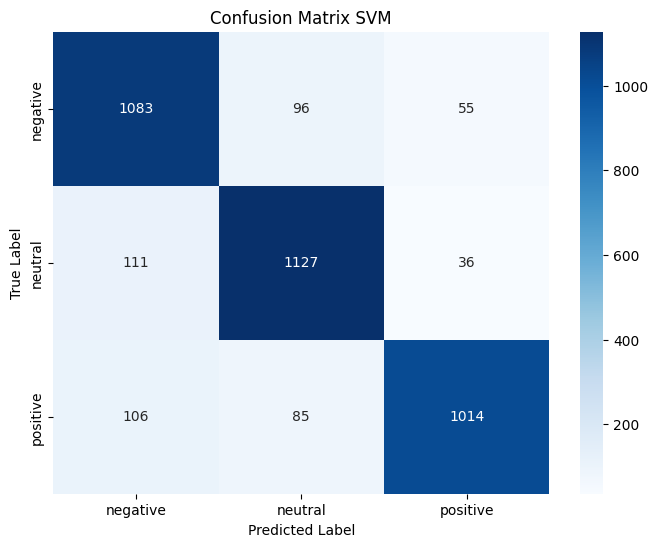

In [184]:
# Akurasi
test_accuracy_svm = accuracy_score(y_test_1, predictions_svm)
print(f"Accuracy SVM: {test_accuracy_svm:.2f}")

# Report
test_report_svm = classification_report(y_test_1, predictions_svm, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report SVM:\n", test_report_svm)

# Confusion Matrix
test_conf_matrix_svm = confusion_matrix(y_test_1, predictions_svm)
print("Confusion Matrix SVM:\n", conf_matrix_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.show()

In [194]:
results_svm = pd.DataFrame({
    'Review': X_test_1,
    'Sentiment': predictions_svm_labels
})
results_svm.to_csv('results_svm', index=True)
results_svm['Sentiment'].value_counts()

Sentiment
Neutral     1308
Negative    1300
Positive    1105
Name: count, dtype: int64

In [195]:
results_svm.sort_index()

,Review,Sentiment
4,gopay later pake topup pulsa bayar game dll ma...,Negative
15,pinjam gopay pinjam penagihannya biadab terlam...,Negative
28,belanja alfa beli pake aplikasi anehnya sy vou...,Negative
32,transfer saldo gopay rekening keterangan trans...,Positive
36,aplikasinya gopaylater gopay pinjamnya rekomen...,Negative
...,...,...
103387,ok,Positive
103426,bagus,Negative
103463,manta,Neutral
103473,bgaus,Neutral


## SVM Model for Word Embedding Scenario

### Training

In [ ]:
# X_train = X_we_train_pca
# X_val = X_we_val_pca
# y_train = y_train_1
# y_val = y_val_1

In [ ]:
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')

In [ ]:
svm_model.fit(X_we_train_pca, y_train_1)

SVC()

### Evaluation

Accuracy GBM: 0.36

Classification Report GBM:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2451
     neutral       0.37      0.88      0.52      2511
    positive       0.32      0.19      0.24      2464

    accuracy                           0.36      7426
   macro avg       0.23      0.36      0.25      7426
weighted avg       0.23      0.36      0.26      7426

Confusion Matrix GBM:
 [[   0 1765  686]
 [   0 2215  296]
 [   0 1995  469]]


c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\Sentiment_Analysis\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

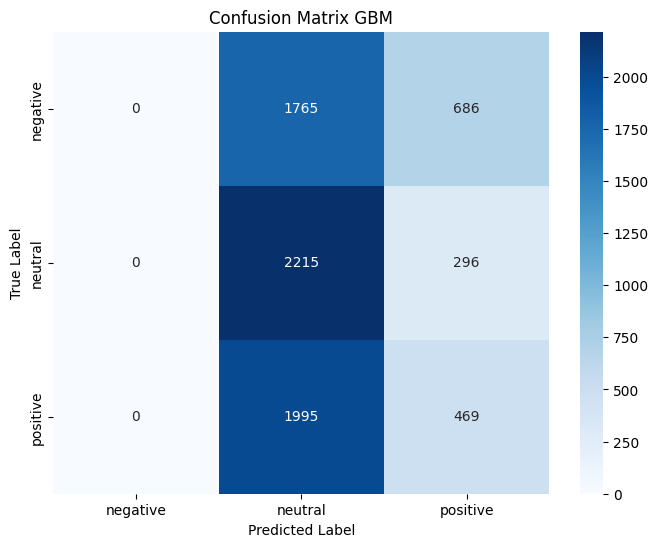

In [131]:
y_pred_svm = svm_model.predict(X_we_val_pca)

# Akurasi
accuracy_svm = accuracy_score(y_val_2, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.2f}")

# Report
report_svm = classification_report(y_val_2, y_pred_svm, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report SVM:\n", report_svm)

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_val_2, y_pred_svm)
print("Confusion Matrix SVM:\n", conf_matrix_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.show()

### Model Testing / Inference

In [ ]:
# Testing_Data
X_we_test.shape

In [ ]:
predictions_gbm = gbm_model.predict(X_we_test)

labeling = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predictions_gbm_labels = [labeling[pred] for pred in predictions_gbm]

In [ ]:
results_gbm = pd.DataFrame({
    'Review': X_test_2,
    'Sentiment': predictions_gbm_labels
})

results_gbm.sort_index()

## RNN Model

### Training

In [237]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping 
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [518]:
# Checkpoint
class checkpoint(Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.92
    
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > self.best_accuracy:
            print(f"\nEpoch {epoch + 1}: val_accuracy is above 92%")

In [238]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10_000, output_dim=128, input_length=200),
    tf.keras.layers.GRU(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 34,179
Trainable params: 34,179
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 50
BATCH = 1024

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = checkpoint()

history_3 = model_3.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

### Evaluation

In [ ]:
test_loss, test_acc = model_3.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

### Model Testing / Inference

# Requirement.txt

In [ ]:
!pip freeze > requirements.txt